In [1]:
import os
from data import import_images
from cellmask_model import CellMaskModel
import matplotlib.pyplot as plt
import numpy as np
import cv2
import ezomero
from omero.gateway import BlitzGateway
import omero.clients

images_path = os.getcwd() + '/images/'
images = import_images(images_path,normalisation=True,num_imgs=5)

c:\Users\rz200\Anaconda3\envs\cellmatch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USERNAME = 'rz200'
PASSWORD = 'omeroreset'
HOST='ome2.hpc.sussex.ac.uk'
PORT=4064

In [4]:
client = omero.client(HOST, PORT)
session = client.createSession(USERNAME, PASSWORD)
conn = BlitzGateway(client_obj=client)

SecurityException: exception ::Ice::SecurityException
{
    reason = SSL handshake failure:
The parameter is incorrect.
}

In [14]:
conn = BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT, secure=True)
conn.connect()
print(conn)

with BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT, secure=True) as conn:
    for p in conn.getObjects('Project'):
        print(p.name)

Exception: Connect failed

In [5]:
conn = BlitzGateway('rz200','omeroreset',group='',host='ome2.hpc.sussex.ac.uk',port=4064,secure=True)
print(conn)

conn.connect()
conn.c.enableKeepAlive(5000)
print(conn)
if conn: print('Connection successful')
else: print('Unsuccessful')

plate = 812
image_ids = ezomero.get_image_ids(conn,plate=plate)
print('In plate',plate,'we have',len(image_ids),'images')

Connection successful


ConnectionLostException: Ice.ConnectionLostException:
recv() returned zero

ConnectionLostException: Ice.ConnectionLostException:
recv() returned zero

In [2]:
model = CellMaskModel()
model.import_model(os.getcwd() + '/saved_weights/cp_model', os.getcwd() + '/saved_weights/mask_model')

instance_masks, masks, cps = model.eval(images) #Making predictions

25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)
25
(1, 1, 256, 256)


In [3]:
def get_encFeats(model,image):
    pad_val = model.expand_div_256(image)[1]
    cp, mask, instance_mask, encFeats_cp, encFeats_mask = model.get_pred(image,0,encFeats=True)
    return encFeats_cp, encFeats_mask, pad_val

def get_encFeats_flat(encFeats,pad_val):
    encFeats_cp_arr = []
    for enc in encFeats:
        arr = enc.detach()
        arr = np.expand_dims(arr,0)
        arr = np.expand_dims(arr,0)
        encFeats_cp_arr.append(arr)
    stacked = model.stack_img(encFeats_cp_arr,colrow=64)
    res = cv2.resize(stacked, dsize=(1280, 1280), interpolation=cv2.INTER_CUBIC)
    res = res[pad_val:-pad_val, pad_val:-pad_val]
    return res

In [4]:
encFeats_cp, encFeats_mask, pad_val = get_encFeats(model,images[0])
get_encFeats_flat_cp = get_encFeats_flat(encFeats_cp,pad_val)
get_encFeats_flat_mask = get_encFeats_flat(encFeats_mask,pad_val)

25
(1, 1, 256, 256)


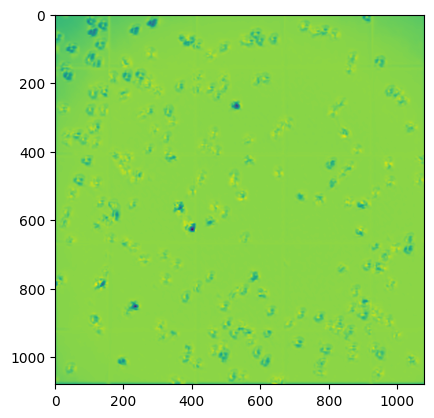

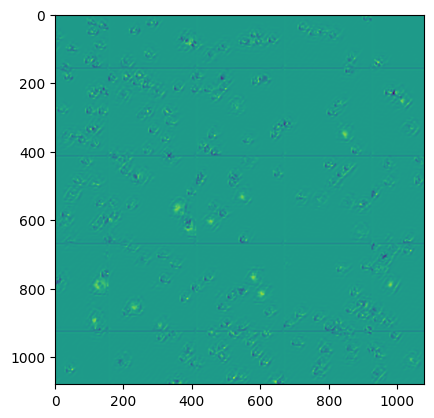

In [7]:
plt.imshow(get_encFeats_flat_cp)
plt.show()

plt.imshow(get_encFeats_flat_mask)
plt.show()

In [40]:
pad_val = model.expand_div_256(images[0])[1]

100


In [3]:
cp, mask, instance_mask, encFeats_cp, encFeats_mask = model.get_pred(images[0],0,encFeats=True)

25
(1, 1, 256, 256)


In [24]:
encFeats_cp_arr = []
for enc in encFeats_cp:
    arr = enc.detach()
    arr = np.expand_dims(arr,0)
    arr = np.expand_dims(arr,0)
    encFeats_cp_arr.append(arr)

In [26]:
stacked = model.stack_img(encFeats_cp_arr,colrow=64)

In [41]:
import cv2

res = cv2.resize(stacked, dsize=(1280, 1280), interpolation=cv2.INTER_CUBIC)
res = res[pad_val:-pad_val, pad_val:-pad_val]

In [45]:
print(images[0].shape)

(1080, 1080, 4)


(-0.5, 1079.5, 1079.5, -0.5)

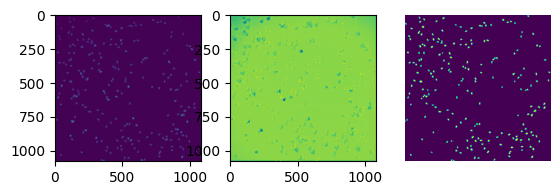

In [52]:
plt.subplot(1,3,1)
plt.imshow(images[0][:,:,0])
plt.subplot(1,3,2)
plt.imshow(res)
plt.subplot(1,3,3)
plt.imshow(mask)
plt.axis('off')

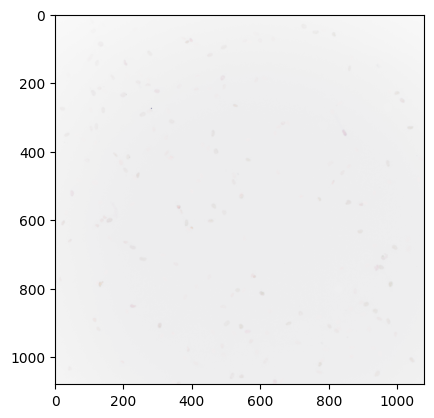

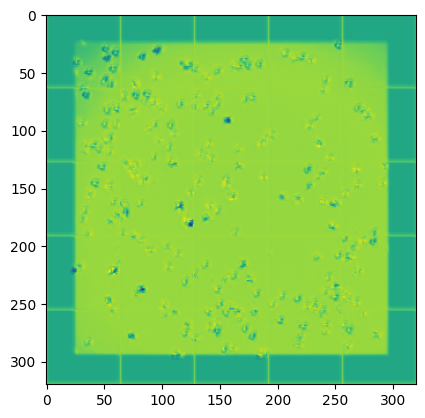

In [30]:
plt.imshow(images[0])
plt.show()

plt.imshow(stacked)
plt.show()

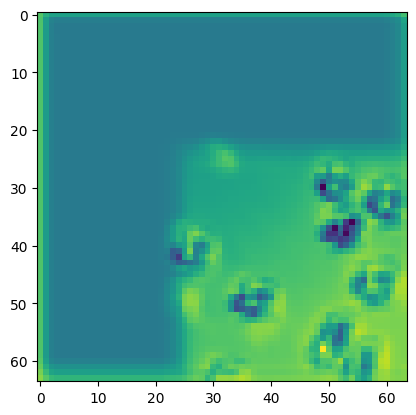

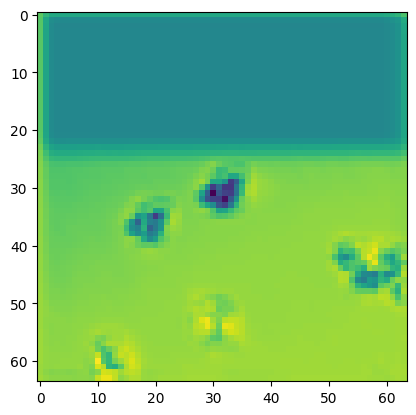

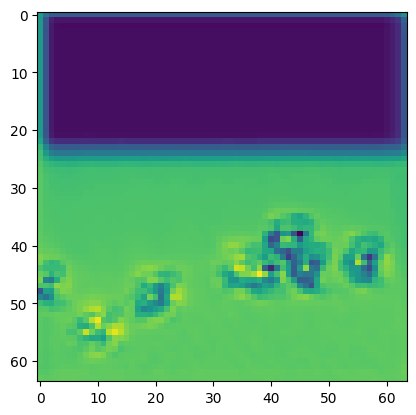

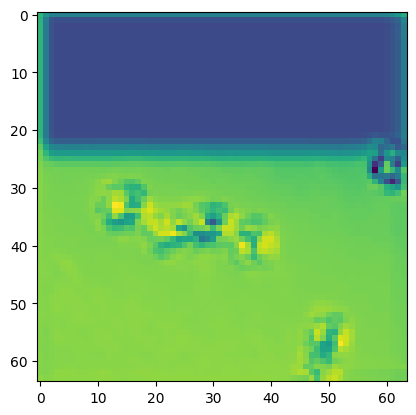

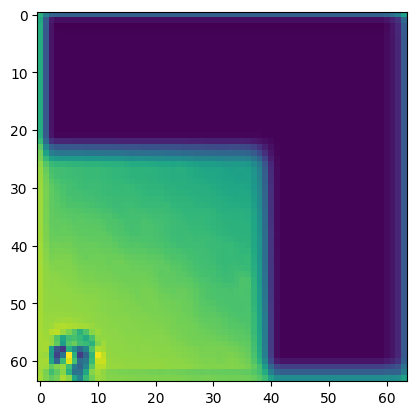

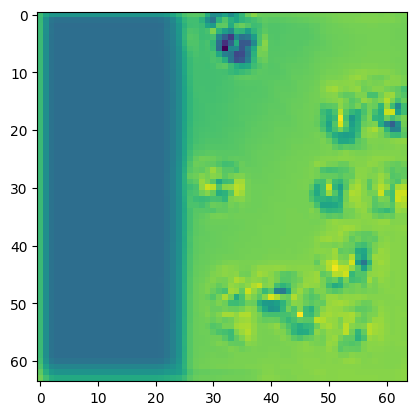

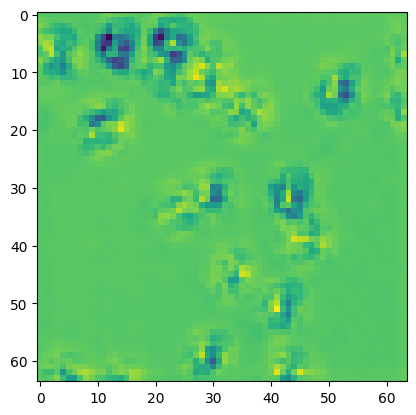

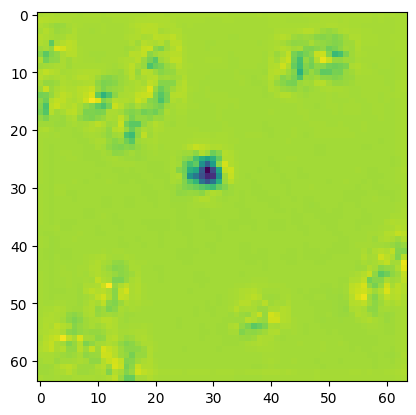

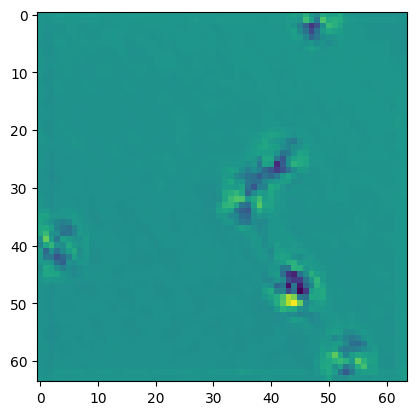

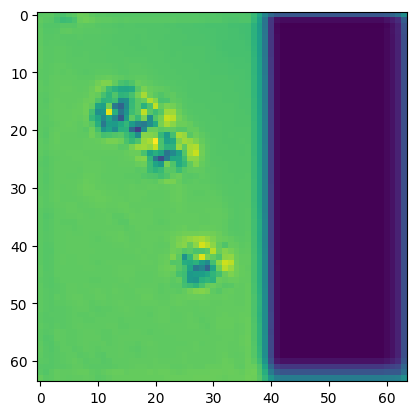

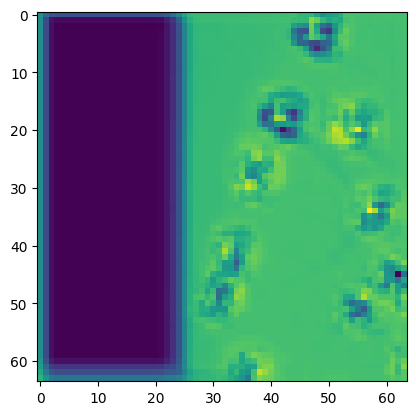

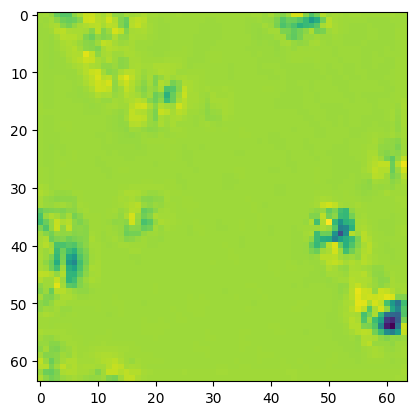

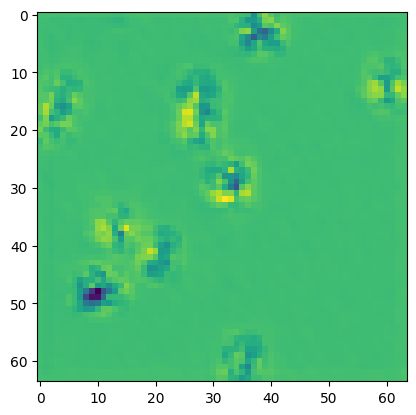

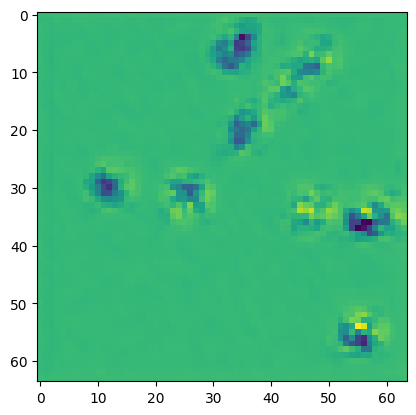

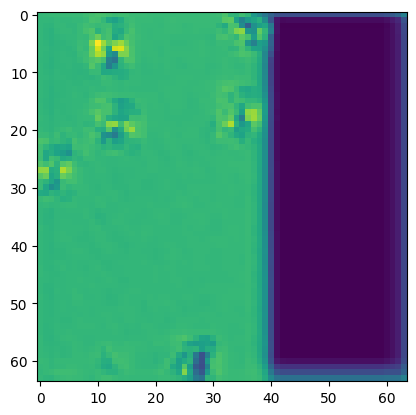

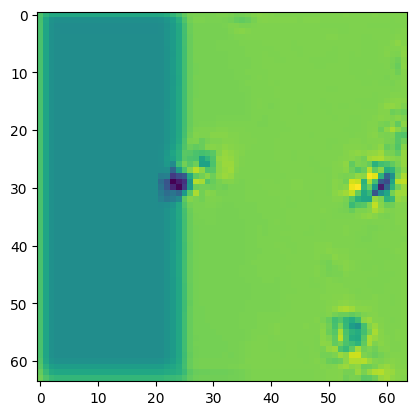

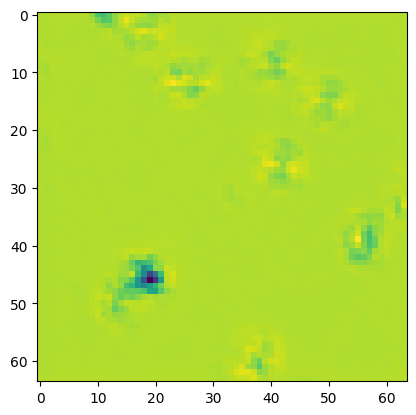

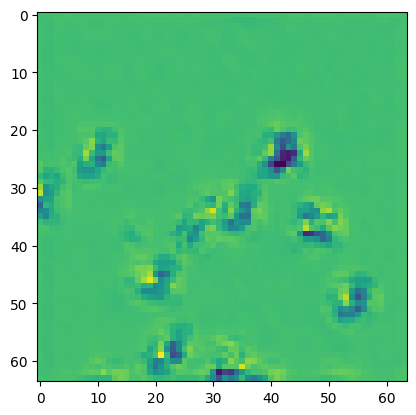

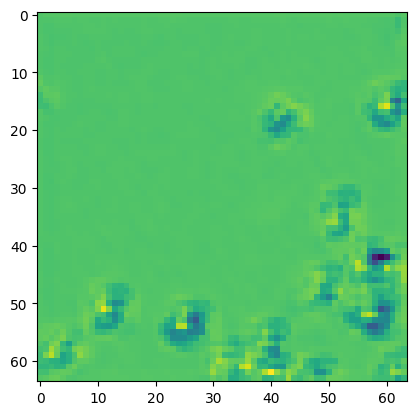

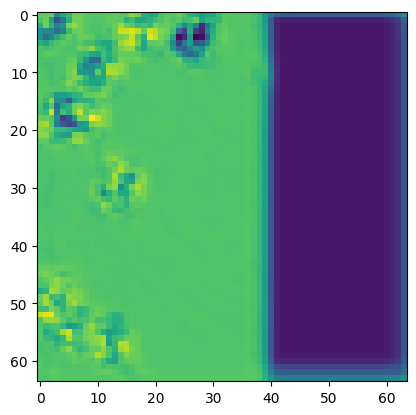

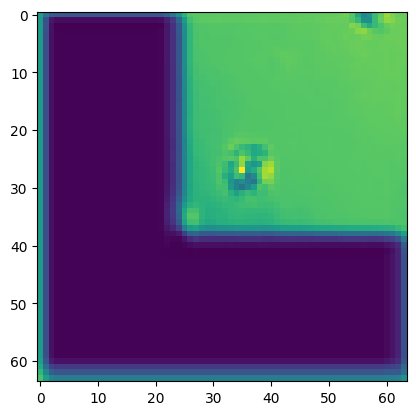

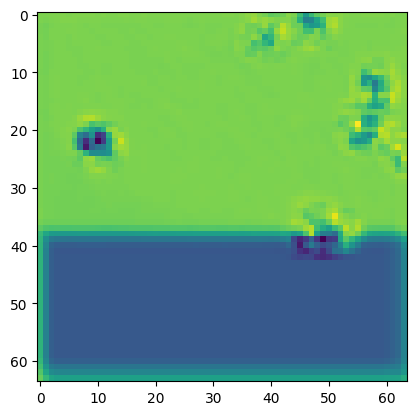

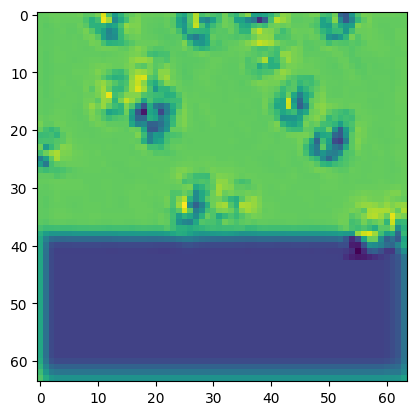

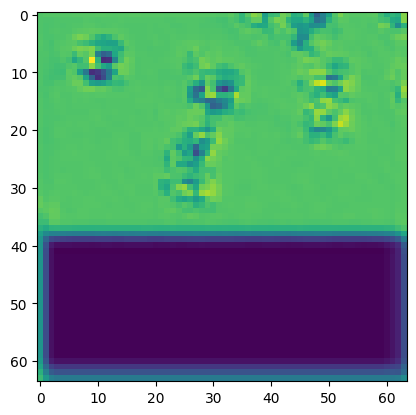

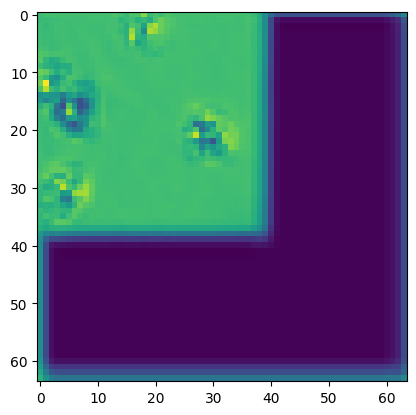

In [11]:
for i in range(len(encFeats_cp)):
    plt.imshow(encFeats_cp[i].detach())
    plt.show()

In [10]:
for i in range(len(encFeats_cp)):
    print(encFeats_cp[i].shape)

torch.Size([1, 16, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])


In [33]:
import torch
encFeats_cp_lowest = encFeats_cp[2][0]
averaged = torch.mean(encFeats_cp_lowest, axis=0)

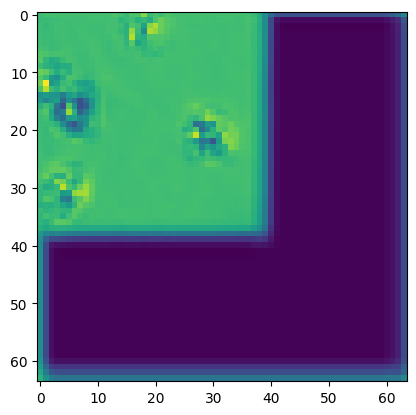

In [7]:
plt.imshow(encFeats_cp.detach())

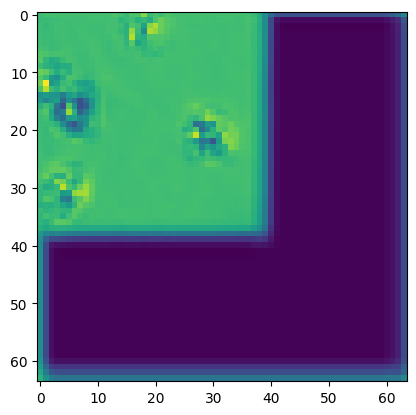

In [35]:
plt.imshow(averaged.detach())

In [26]:
x = np.random.rand(64, 100, 100)

# average across the first axis (i.e., the channels)
x_avg = np.mean(x, axis=0)

# x_avg now has one channel and the same shape as the other axes of x
print(x_avg.shape)

(100, 100)
